Model has 994k params
Initial training loss: 3.7646985054016113, val loss: 3.7603843212127686
iter:0 training loss: 3.7670373916625977, val loss: 3.767575263977051
iter:100 training loss: 1.4202960729599, val loss: 1.4177132844924927
iter:200 training loss: 1.4059748649597168, val loss: 1.4031693935394287
iter:300 training loss: 1.3316000699996948, val loss: 1.3367674350738525
iter:400 training loss: 1.0868741273880005, val loss: 1.0761831998825073
iter:500 training loss: 0.7747641205787659, val loss: 0.7758517265319824
iter:600 training loss: 0.3822195827960968, val loss: 0.37649476528167725
iter:700 training loss: 0.2881365120410919, val loss: 0.3121223747730255
iter:800 training loss: 0.11466371268033981, val loss: 0.11055545508861542
iter:900 training loss: 0.03908917307853699, val loss: 0.03867078199982643
iter:1000 training loss: 0.011414260603487492, val loss: 0.01016976684331894
iter:1100 training loss: 0.012829266488552094, val loss: 0.01489916443824768
iter:1200 training loss

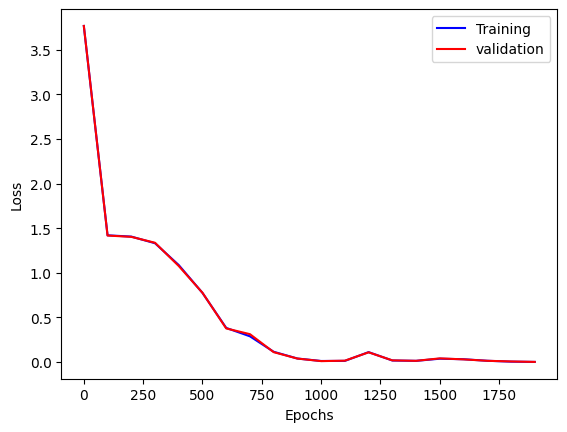

In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import time
import random
import math

PATH = "models/addition_1M.bin"
LOAD_MODEL = False

inf = torch.inf

max_digits = 4 # 0 to 10**(x -1)
context_length = 3*max_digits + 2 # {max_digits+max_digits=max_digits}
model_dim = 128 # dimension of the model -> residual stream
n_layers = 6 # no of layers
vocab_size = 14
head_dim = 64
learning_rate = 3e-4
max_iters = 2000
eval_iters = 100
batch_size = 32 



lower_triangular_matrix = torch.tensor([[1 if i<=j else -torch.inf for i in range(context_length)] for j in range(context_length)]).float()

def tokenise(str: str):
    tokens = []
    for i in list(str):
        if i in set(list("0123456789")):
            tokens.append(int(i))
        if i == "+":
            tokens.append(11)
        if i == "=":
            tokens.append(12)
        if i == "\n":
            tokens.append(13)
    return tokens
        

def decode(tokens: list[int]):
    reverse_char_map = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 11: '+', 12: '=', 13: '\n'}
    return ''.join([reverse_char_map[i] for i in tokens])

def convert_to_str(a: int):
    n = len(str(a))
    return (max_digits-n)*'0' + str(a)

def sample_data(split: str = "train"): # With replacement
    X = torch.zeros(batch_size, context_length).long()
    Y = torch.zeros(batch_size, context_length).long()

    for i in range(batch_size):
        a = random.randint(0,10**(max_digits-1))
        b = random.randint(0,10**(max_digits-1))
        c = a + b
        x = tokenise(f"{convert_to_str(a)}+{convert_to_str(b)}={convert_to_str(c)[::-1]}")
        y = x[1:] + [13]

        X[i, :len(x)] = torch.tensor(x)
        Y[i, :len(y)] = torch.tensor(y)

    return X, Y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = sample_data(split)
            _, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    
    return out["train"], out['val']


class Layer(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        

class AttentionHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.key = nn.Linear(model_dim, head_dim)
        self.query = nn.Linear(model_dim, head_dim)
        self.value = nn.Linear(model_dim, head_dim)
        self.proj = nn.Linear(head_dim, model_dim)
    
    def forward(self, idx):
        key = self.key(idx) # (batch, context_length, head_dim)
        query = self.query(idx)
        value = self.value(idx) # (batch, context_length, head_dim)

        attention = (query@torch.transpose(key,1,2))/(math.sqrt(head_dim)) # (batch, context_length, context_length)

        attention = torch.tril(attention)

        attention = attention.masked_fill(attention == 0, -inf)

        attention = F.softmax(attention,-1) # probs along context_length sum to 1

        attention_value = attention@value  # (batch, context_length, head_dim)

        return self.proj(attention_value)  # (batch, context_length, model_dim)
    

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(model_dim, 4*model_dim), nn.Linear(4*model_dim, model_dim))
        self.relu = nn.ReLU()
    
    def forward(self, idx):
        logits = self.layers(idx)
        return self.relu(logits)

class Transformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, model_dim)
        self.pos_embedding = nn.Embedding(context_length, model_dim)
        self.attention_layes = nn.ModuleList([AttentionHead() for i in range(n_layers)])
        self.mlp_layers = nn.ModuleList([MLP() for i in range(n_layers)])
        self.unembed_layer = nn.Linear(model_dim,vocab_size)

        self.total_parameters = sum([p.numel() for p in self.parameters()])
        print(f"Model has {self.total_parameters//1000}k params")


    def forward(self, idx, targets = None):
        # idx -> [1,2,0,3..] (batch, context_length)

        # for p in range(idx.shape[0]):
        #     print([decode(idx[p].tolist()), decode(targets[p].tolist())])

        input_sequence_length = idx.shape[-1]

        residual_stream = self.token_embedding(idx)  # (batch, context_length, model_dim)
        residual_stream = residual_stream + self.pos_embedding(torch.tensor([i for i in range(input_sequence_length)])) # Pos embedding will be # (context_length, model_dim)
        
        for i in range(n_layers):
            residual_stream = residual_stream + self.attention_layes[i](residual_stream)
            residual_stream = residual_stream + self.mlp_layers[i](residual_stream)

        residual_stream = self.unembed_layer(residual_stream) # (batch, context_length, vocab_size)
        if targets is None:
            return residual_stream
        
        
        # residual_stream = residual_stream[:,9:,:]
        # targets = targets[:,9:]


        (x,y,z) = residual_stream.shape

        # print(residual_stream.shape, targets.shape)

        starting_index_to_calculate_loss = 2*max_digits+1
        residual_stream = residual_stream[:,starting_index_to_calculate_loss:,:]
        targets= targets[:,starting_index_to_calculate_loss:]

        (x,y,z) = residual_stream.shape

        loss = F.cross_entropy(residual_stream.reshape(x*y,z), targets.reshape(x*y))
        return residual_stream, loss
    
model = Transformer()


if LOAD_MODEL:
    model = Transformer()
    model.load_state_dict(torch.load(PATH))
    model.eval()

train_loss,val_loss = estimate_loss()
print(f"Initial training loss: {train_loss}, val loss: {val_loss}")

loss_value = []
val_loss_value = []
iters = []
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
step_value = max_iters/20
start_time = time.time()
for iter in range(max_iters):
    X,Y= sample_data() # (B, context_length)
    logits, loss = model(X, Y)  # (B, context_length, vocab_size)
    if iter%step_value ==0:
        train_loss,val_loss = estimate_loss()
        iters.append(iter)
        loss_value.append(train_loss)
        val_loss_value.append(val_loss)
        print(f"iter:{iter} training loss: {train_loss}, val loss: {val_loss}")

    
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
end_time = time.time()
print(f"Took {end_time-start_time}s for {max_iters} epochs")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(iters,loss_value, color='blue', label="Training")
plt.plot(iters, val_loss_value, "red", label = "validation")
plt.legend()
plt.show()



        

In [2]:
def generate_text(input: str):
    max_tokens = max_digits
    input_tokens = torch.tensor(tokenise(input))
    #print(input, end='')
    out = []
    
    for i in range(max_tokens):
        now = model(input_tokens.unsqueeze(0))[0][-1]
        now = F.softmax(now, dim= 0)
        token = torch.multinomial(now,1).item()
        input_tokens = torch.tensor(input_tokens.tolist() + [token])
        text = decode([token])
        #print(text, end='')
        out.append(text)
        input_tokens = input_tokens[-context_length:]
    return out
                
true = 0
tot = 0

for i in range(1000):
    tot+=1
    a = random.randint(0,10**(max_digits-1))
    b = random.randint(0,10**(max_digits-1))
    expected = a + b
    input = f"{convert_to_str(a)}+{convert_to_str(b)}="
    sum = int(''.join(generate_text(input)[::-1]))
    if sum == expected:
        true+=1

print(f"Accuracy {true*100/tot}%")

    


Accuracy 99.9%


In [55]:
PATH = "models/addition_1M_95_accuracy.bin"
torch.save(model.state_dict(), PATH)


In [57]:
def get_aacuracy():

['6', '2', '4', '6', '4', '0']

Model has 994k params
Initial training loss: 3.3873138427734375, val loss: 3.3922269344329834
iter:0 training loss: 3.408843994140625, val loss: 3.3857181072235107
iter:100 training loss: 1.6610537767410278, val loss: 1.665318489074707
iter:200 training loss: 1.5506254434585571, val loss: 1.5506373643875122
iter:300 training loss: 1.4972867965698242, val loss: 1.4959781169891357
iter:400 training loss: 1.4525463581085205, val loss: 1.4549299478530884
iter:500 training loss: 1.4220234155654907, val loss: 1.4223618507385254
iter:600 training loss: 1.424903392791748, val loss: 1.4253453016281128
iter:700 training loss: 1.391689419746399, val loss: 1.3917254209518433
iter:800 training loss: 1.2421270608901978, val loss: 1.2408753633499146
iter:900 training loss: 1.1952933073043823, val loss: 1.192704439163208
iter:1000 training loss: 0.782135546207428, val loss: 0.7829391360282898
iter:1100 training loss: 0.36436977982521057, val loss: 0.3636614680290222
iter:1200 training loss: 0.11650767

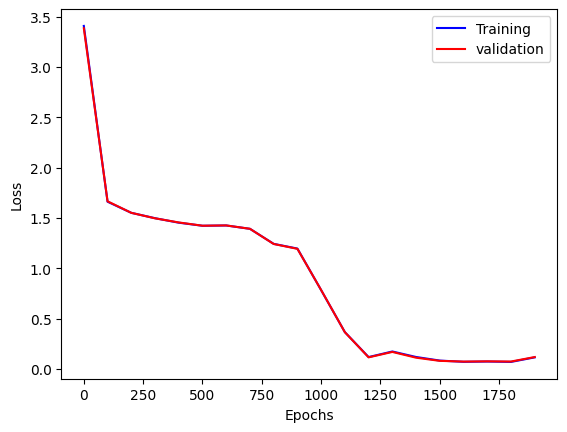

In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import time
import random
import math

PATH = "models/addition_1M.bin"
LOAD_MODEL = False

inf = torch.inf

max_digits = 6 # 0 to 10**(x -1)
context_length = 3*max_digits + 2 # {max_digits+max_digits=max_digits}
model_dim = 128 # dimension of the model -> residual stream
n_layers = 6 # no of layers
vocab_size = 14
head_dim = 64
learning_rate = 3e-4
max_iters = 2000
eval_iters = 100
batch_size = 32



lower_triangular_matrix = torch.tensor([[1 if i<=j else -torch.inf for i in range(context_length)] for j in range(context_length)]).float()

def tokenise(str: str):
    tokens = []
    for i in list(str):
        if i in set(list("0123456789")):
            tokens.append(int(i))
        if i == "+":
            tokens.append(11)
        if i == "=":
            tokens.append(12)
        if i == "\n":
            tokens.append(13)
    return tokens
        

def decode(tokens: list[int]):
    reverse_char_map = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 11: '+', 12: '=', 13: '\n'}
    return ''.join([reverse_char_map[i] for i in tokens])

def convert_to_str(a: int):
    n = len(str(a))
    return (max_digits-n)*'0' + str(a)

def sample_data(split: str = "train"): # With replacement
    X = torch.zeros(batch_size, context_length).long()
    Y = torch.zeros(batch_size, context_length).long()

    for i in range(batch_size):
        a = random.randint(0,10**(max_digits-1))
        b = random.randint(0,10**(max_digits-1))
        c = a + b
        x = tokenise(f"{convert_to_str(a)}+{convert_to_str(b)}={convert_to_str(c)}")
        y = x[1:] + [13]

        X[i, :len(x)] = torch.tensor(x)
        Y[i, :len(y)] = torch.tensor(y)

    return X, Y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = sample_data(split)
            _, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    
    return out["train"], out['val']


class Layer(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        

class AttentionHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.key = nn.Linear(model_dim, head_dim)
        self.query = nn.Linear(model_dim, head_dim)
        self.value = nn.Linear(model_dim, head_dim)
        self.proj = nn.Linear(head_dim, model_dim)
    
    def forward(self, idx):
        key = self.key(idx) # (batch, context_length, head_dim)
        query = self.query(idx)
        value = self.value(idx) # (batch, context_length, head_dim)

        attention = (query@torch.transpose(key,1,2))/(math.sqrt(head_dim)) # (batch, context_length, context_length)

        attention = torch.tril(attention)

        attention = attention.masked_fill(attention == 0, -inf)

        attention = F.softmax(attention,-1) # probs along context_length sum to 1

        attention_value = attention@value  # (batch, context_length, head_dim)

        return self.proj(attention_value)  # (batch, context_length, model_dim)
    

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(model_dim, 4*model_dim), nn.Linear(4*model_dim, model_dim))
        self.relu = nn.ReLU()
    
    def forward(self, idx):
        logits = self.layers(idx)
        return self.relu(logits)

class Transformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, model_dim)
        self.pos_embedding = nn.Embedding(context_length, model_dim)
        self.attention_layes = nn.ModuleList([AttentionHead() for i in range(n_layers)])
        self.mlp_layers = nn.ModuleList([MLP() for i in range(n_layers)])
        self.unembed_layer = nn.Linear(model_dim,vocab_size)

        self.total_parameters = sum([p.numel() for p in self.parameters()])
        print(f"Model has {self.total_parameters//1000}k params")


    def forward(self, idx, targets = None):
        # idx -> [1,2,0,3..] (batch, context_length)

        # for p in range(idx.shape[0]):
        #     print([decode(idx[p].tolist()), decode(targets[p].tolist())])

        input_sequence_length = idx.shape[-1]

        residual_stream = self.token_embedding(idx)  # (batch, context_length, model_dim)
        residual_stream = residual_stream + self.pos_embedding(torch.tensor([i for i in range(input_sequence_length)])) # Pos embedding will be # (context_length, model_dim)
        
        for i in range(n_layers):
            residual_stream = residual_stream + self.attention_layes[i](residual_stream)
            residual_stream = residual_stream + self.mlp_layers[i](residual_stream)

        residual_stream = self.unembed_layer(residual_stream) # (batch, context_length, vocab_size)
        if targets is None:
            return residual_stream
        
        
        # residual_stream = residual_stream[:,9:,:]
        # targets = targets[:,9:]


        (x,y,z) = residual_stream.shape

        # print(residual_stream.shape, targets.shape)

        starting_index_to_calculate_loss = 2*max_digits+1
        residual_stream = residual_stream[:,starting_index_to_calculate_loss:,:]
        targets= targets[:,starting_index_to_calculate_loss:]

        (x,y,z) = residual_stream.shape

        loss = F.cross_entropy(residual_stream.reshape(x*y,z), targets.reshape(x*y))
        return residual_stream, loss
    
model = Transformer()


if LOAD_MODEL:
    model = Transformer()
    model.load_state_dict(torch.load(PATH))
    model.eval()

train_loss,val_loss = estimate_loss()
print(f"Initial training loss: {train_loss}, val loss: {val_loss}")

loss_value = []
val_loss_value = []
iters = []
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
step_value = max_iters/20
start_time = time.time()
for iter in range(max_iters):
    X,Y= sample_data() # (B, context_length)
    logits, loss = model(X, Y)  # (B, context_length, vocab_size)
    if iter%step_value ==0:
        train_loss,val_loss = estimate_loss()
        iters.append(iter)
        loss_value.append(train_loss)
        val_loss_value.append(val_loss)
        print(f"iter:{iter} training loss: {train_loss}, val loss: {val_loss}")

    
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
end_time = time.time()
print(f"Took {end_time-start_time}s for {max_iters} epochs")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(iters,loss_value, color='blue', label="Training")
plt.plot(iters, val_loss_value, "red", label = "validation")
plt.legend()
plt.show()



        

In [2]:
def generate_text(input: str):
    max_tokens = max_digits
    input_tokens = torch.tensor(tokenise(input))
    #print(input, end='')
    out = []
    
    for i in range(max_tokens):
        now = model(input_tokens.unsqueeze(0))[0][-1]
        now = F.softmax(now, dim= 0)
        token = torch.multinomial(now,1).item()
        input_tokens = torch.tensor(input_tokens.tolist() + [token])
        text = decode([token])
        #print(text, end='')
        out.append(text)
        input_tokens = input_tokens[-context_length:]
    return out
                
true = 0
tot = 0

for i in range(1000):
    tot+=1
    a = random.randint(0,10**(max_digits-1))
    b = random.randint(0,10**(max_digits-1))
    expected = a + b
    input = f"{convert_to_str(a)}+{convert_to_str(b)}="
    sum = int(''.join(generate_text(input)))
    if sum == expected:
        true+=1

print(f"Accuracy {true*100/tot}%")

    


Accuracy 77.3%


In [3]:
generate_text("012301+034125=")

['0', '4', '6', '4', '2', '6']